<font size=5.5><b> Задача мэтчинга товаров </b></font>

**Заказчик работы (исследования):** Один из крупнейших маркетплейсов страны. <br>
**Исходные данные:** Имеются базовая, обучающая и валидационная выборки, содержащие анонимизированный набор информации о товарах - в виде векторов признаков заданной длины.<br>
**Цель работы:** Разработать и протестировать алгоритм (в т.ч., с использованием, при необходимости - для решения дополнительной задачи ранжирования, ML-модели), позволяющий каждому товару из валидационной выборки сопоставить наиболее близкие товары из базовой выборки (по заданной метрике качества).<br>

## Загрузка и ознакомление с данными из датасетов

### Загрузка данных из исходных файлов

Импортируем требуемые библиотеки и загрузим в переменные (исходные датафреймы) `df_base`, `df_train`, `df_test` и `y_test` данные из соответствующих файлов. Дополнительным условием является наличие установленной библиотеки `faiss`, а также библиотеки `phik` (забегая вперед - она не очень нужна в этом проекте, но мы все-таки проверим данные на мультиколлениарность).

In [1]:
# импортируем требуемые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import faiss

from sklearn.preprocessing import StandardScaler, RobustScaler

import phik
from phik.report import plot_correlation_matrix

# from tqdm import tqdm

In [2]:
# введем глобальные переменные и зададим random_state
# RANDOM_STATE_CONST = 42
# np.random.seed(0)
# KF = 5 # количество фолдов (блоков) кросс-валидации
K_NEIGHBORS = 5

In [3]:
%%time
# загрузим данные из файлов
try:
    # датасеты расположены на локальном хосте
    df_base = pd.read_csv('datasets/base.csv', index_col=0) # данные базового датафрейма
    df_train = pd.read_csv('datasets/train.csv', index_col=0) # данные обучающего датафрейма
    df_test = pd.read_csv('datasets/validation.csv', index_col=0) # данные тестового датафрейма
    y_test = pd.read_csv('datasets/validation_answer.csv', index_col=0) # данные тестового целевого признака
    print('local')
except:
#     # датасеты расположены в сети
#     df_base = pd.read_csv('https://code.s3.yandex.net/datasets/base.csv') # данные базового датафрейма
#     df_train = pd.read_csv('https://code.s3.yandex.net/datasets/train.csv') # данные обучающего датафрейма
#     df_test = pd.read_csv('https://code.s3.yandex.net/datasets/validation.csv') # данные тестового датафрейма
#     y_test = pd.read_csv('https://code.s3.yandex.net/datasets/validation_answer.csv') # данные тестового целевого прзинака
#     print('net')
    print('Пожалуйста, разместите исходные датасеты в папке /datasets')

local
CPU times: total: 59.6 s
Wall time: 1min 30s


### Обзор исходных датафреймов

Выполним предварительный обзор исходных датафреймов - посмотрим на данные в загруженных исходных датафреймах.<br>
Для проведения обзора загруженных данных исходных датафреймов (датасетов) создадим функцию `df_review_function`, которая будет выводить следующую основную информацию о признаках, содержащихся в датафреймах:
- заданное количество первых строк датафрейма (от начала);
- краткую информацию о типах данных признаков и наличии пропущенных значений;
- некоторые статистические сведения о признаках датафрейма.

In [4]:
# установим вывод всех столбцов датафрейма
pd.set_option('display.max_columns', None)

In [5]:
def df_review_function(df, n_head_lines=5):
    """ Функция для предварительного обзора загруженных данных
        входные параметры функции:
        df - датафрейм для анализа
        n_head_lines - количество выводимых строк датафрейма (от начала) """
    
    # выведем первые head_lines строк датафрейма
    print('Первые строки датафрейма:')
    display(df.head(n_head_lines)); print('\n')
    
    # выведем основную информацию о датафрейме
    print('Краткая информация о датафрейме:', '\n');
    df.info(), print('\n') 
    print('Количество пропущенных значений признаков:', '\n');
    display(df.isna().sum()), print('\n')

    # выведем основную статистическую информацию о датафрейме
    print('Краткая статистическая информация о датафрейме:');
    display(df.describe(), print('\n'));

#### Обзор базового датасета

Выполним краткий обзор базового датасета с использованием разработанной функции `df_review_function`.

In [6]:
# обзор базового датафрейма
df_review_function(df_base, 5)

Первые строки датафрейма:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62



Краткая информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64



Краткая статистическая информация о датафрейме:




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,-1.431396e+02,-6.988662e+01,-4.126493e+01,7.587780e+00,1.489852e+02,-2.316701e+01,-9.366916e-01,-1.931312e+01,-1.372712e+02,-7.918932e+01,-9.825383e+01,1.257528e+03,-6.824936e+00,5.667382e+01,2.669563e+01,7.271026e+02,-6.625340e+01,1.631537e+01,-8.637482e+01,1.517346e+02,-1.160764e+01,-1.442328e+02,8.721997e+01,-5.541608e+02,3.623933e+01,7.519918e+01,-1.648670e+01,-1.466421e+02,-1.185122e+02,-4.187896e+01,-9.482269e+00,4.050654e+00,-1.127440e+02,1.208653e+02,-3.980939e+01,5.893878e+01,-8.488885e+01,-1.384695e+02,4.792759e+01,-3.238229e+01,2.658408e+01,-2.171709e+01,6.699684e+01,-1.178976e+02,8.802818e+01,6.920454e+01,-1.329056e+02,1.322645e+01,-1.195996e+02,-3.160935e+02,-6.494332e+01,-1.306677e+02,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,4.168737e+01,5.121991e+01,3.896358e+01,3.659725e+01,3.363559e+01,1.307563e+01,2.083201e+01,5.297210e+01,4.662566e+01,7.574403e-01,2.815861e+01,3.999612e+02,5.197251e+01,3.436061e+01,3.894157e+01,2.055724e+02,6.153334e+01,4.656628e+00,4.851313e+01,1.009000e+01,2.895059e+01,3.475739e+01,2.785556e+01,2.606486e+02,3.989506e+01,2.144713e+01,2.585462e+01,9.953913e+00,1.314411e+01,1.919689e+01,8.190720e+00,5.835750e+00,5.694050e+01,4.671995e+01,1.474482e+01,3.211030e+01,6.319335e+01,5.773822e+01,4.520157e+01,5.828693e+01,5.895291e+01,5.173898e+01,1.307173e+01,5.470584e+01,4.774309e+00,1.194907e+01,7.815245e+00,5.107988e+01,5.524317e+01,2.106644e+02,6.248236e+01,9.569063e+00,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,-3.438436e+02,-3.684526e+02,-2.260906e+02,-1.756239e+02,-1.526698e+01,-8.591711e+01,-9.636816e+01,-2.725656e+02,-3.517478e+02,-8.315235e+01,-2.437279e+02,1.368182e+02,-2.382874e+02,-8.818329e+01,-1.431833e+02,-6.198046e+01,-3.585515e+02,-8.364693e+00,-3.140082e+02,1.074433e+02,-1.567305e+02,-2.986792e+02,-3.465488e+01,-1.045312e+03,-1.378509e+02,-2.151936e+01,-1.379866e+02,-1.954172e+02,-1.769110e+02,-1.327073e+02,-4.757769e+01,-2.158085e+01,-3.381192e+02,-8.770834e+01,-6.310310e+01,-7.724959e+01,-3.629306e+02,-4.186953e+02,-1.453876e+02,-3.228121e+02,-2.802731e+02,-2.646334e+02,6.196133e+00,-3.812643e+02,6.558115e+01,1.408166e+01,-1.670627e+02,-1.961836e+02,-3.597054e+02,-6.810424e+02,-4.007911e+02,-1.713491e+02,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.95094

None

#### Обзор обучающего датасета

Выполним краткий обзор обучающего датасета с использованием разработанной функции `df_review_function`.

In [7]:
# обзор обучающего датафрейма
df_review_function(df_train, 5)

Первые строки датафрейма:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.51707,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.90683,-78.789320,-78.73709,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.22893,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.95837,-30.800995,123.623400,-37.540867,-72.13980,71.240990,-168.115590,118.23645,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-379.339090,-153.465770,-131.19829,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.15302,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.55463,-79.066610,-77.92646,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.56077,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.18497,-53.147078,79.869446,-151.131350,-45.05616,79.796234,46.763016,47.68181,-



Краткая информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20   

0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64



Краткая статистическая информация о датафрейме:




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,-141.168584,-69.228444,-42.559541,6.506719,149.077582,-23.942253,-2.219093,-12.964439,-138.714610,-79.159795,-97.474574,1297.269578,-3.600685,55.908014,23.470181,742.788817,-64.970553,16.368072,-86.201170,152.098083,-13.659323,-144.506022,89.747894,-587.551768,36.468210,73.109595,-13.866967,-146.487267,-118.336458,-41.131969,-9.261504,4.139978,-104.928806,122.240784,-40.320211,59.051981,-84.054387,-140.787854,46.137851,-34.136875,29.462927,-22.343451,67.581086,-120.052756,88.193676,69.538752,-132.336967,14.452681,-120.301843,-315.282239,-66.378660,-130.672183,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,41.607785,51.258647,40.819544,37.593800,34.167843,13.024184,20.978943,55.210920,48.737245,0.775560,28.382144,375.123794,50.063680,35.617513,40.802653,191.052074,63.160650,4.828575,49.511818,10.392531,29.191689,35.816357,28.312124,273.294442,39.756311,20.008170,25.824911,10.383975,13.578397,19.868303,8.295381,5.922103,56.519443,48.109909,14.739497,31.088173,66.055063,59.851232,46.328286,59.325454,60.934591,54.991787,12.988132,55.920785,4.824051,12.339684,7.952113,49.234745,55.730177,210.657513,64.913422,9.408099,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,-330.570600,-352.405200,-214.742460,-145.860280,8.818390,-82.645004,-91.657020,-247.589280,-326.648740,-82.637184,-228.808260,136.873137,-211.971800,-87.323780,-122.584274,-61.803358,-338.562500,-6.629074,-285.668700,111.387250,-130.444920,-290.124000,-25.550720,-1044.135662,-119.903810,-11.926712,-124.560380,-193.918150,-166.078460,-123.062420,-43.063824,-18.980648,-324.943570,-67.540375,-63.102401,-64.789690,-327.322720,-365.060880,-129.879180,-280.371830,-250.337570,-236.148470,18.477040,-354.915700,66.068665,18.104557,-161.189320,-183.849880,-330.638180,-681.029305,-358.460450,-169.566400,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,-168.599020,-103.048815,-69.801705,-18.815189,126.369124,-32.379752,-16.455603,-49.612492,-171.661355,-79.656816,-115.407545,1248.126198,-37.047511,31.436791,-5.051067,813.770071,-106.860569,13.187895,-119.613590,145.143008,-32.812503,-168.535163,70.432237,-803.390708,9.505674,59.978086,-30.926924,-153.339210,-127.603408,

None

#### Обзор тестового датасета

Выполним краткий обзор тестового датасета с использованием разработанной ранее функции `df_review_function`.

In [8]:
# обзор тестового датафрейма
df_review_function(df_test, 5)

Первые строки датафрейма:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.27196,-71.406456,-65.349320,24.377070,50.46730,-14.721335,15.069309,-46.682995,-176.60437,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.69241,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.04887,-57.156870,-56.335075,-318.680065,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.21417,-26.393860,34.423640,50.938890,157.68318,-23.786497,-33.175415,-0.592607,-193.31854,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.25737,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255



Краткая информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20 

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64



Краткая статистическая информация о датафрейме:




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.302233,7.669724,-43.842474,-146.119797,111.635071,-73.273042,-441.396759,21.594242,123.077725,126.001062,-141.215384,-69.340237,-42.626768,6.272022,149.006081,-23.961728,-2.009594,-13.151269,-138.540600,-79.162680,-97.356361,1301.395163,-3.439855,56.097825,23.357262,741.156981,-64.986388,16.367853,-86.139332,152.078754,-13.476064,-144.568331,89.709031,-588.597042,36.554961,73.085400,-13.889099,-146.461500,-118.391474,-40.992214,-9.193917,4.157828,-104.775965,122.095524,-40.311826,59.123753,-83.620997,-141.003063,46.187760,-34.154328,29.404870,-22.542637,67.486142,-120.307717,88.174847,69.495540,-132.377437,14.411927,-120.381837,-316.401557,-66.614887,-130.653256,-81.129311,36.778882,-152.341249,14.397762,67.788892,23.250779,73.114446,115.196935,-709.457021,-48.416276
std,25.777321,4.956990,39.138775,20.495541,47.751576,28.515740,279.242585,66.478048,6.504931,64.981697,41.568432,51.483403,40.858017,37.845939,34.031665,13.014670,20.993654,55.340411,48.790143,0.777431,28.503558,371.543911,50.291410,35.599512,40.849607,193.199671,63.274623,4.845841,49.511970,10.406558,29.275776,35.911251,28.430405,273.788805,39.610961,20.044353,25.802824,10.389778,13.602543,19.845968,8.364438,5.910225,56.986969,48.130993,14.753263,31.126990,65.925312,59.595488,45.996789,59.611850,60.943297,55.140398,13.036243,56.107653,4.809309,12.324416,7.894675,49.387024,55.818220,211.131373,65.195278,9.426921,30.691590,25.427103,41.246347,98.695231,1.844522,55.403862,62.056224,21.493081,405.665764,41.292843
min,-190.353330,-11.109877,-217.538420,-220.050890,-81.198990,-176.705030,-791.460243,-265.608430,96.218350,-135.667300,-321.544250,-363.493320,-204.299130,-144.100740,-14.816055,-78.597450,-86.843280,-272.565600,-329.860170,-82.665300,-231.376650,136.846377,-208.900850,-84.224530,-138.217000,-61.879841,-341.962220,-6.662937,-282.249330,110.357254,-150.154720,-281.123540,-24.076744,-1044.135662,-117.473145,-17.641396,-124.311615,-194.132930,-166.124450,-126.336075,-43.321170,-19.319794,-326.301300,-79.304720,-63.102401,-76.792040,-365.282530,-375.452200,-121.267914,-277.375920,-279.886380,-234.521500,12.404751,-381.609380,65.986030,17.301888,-162.872990,-156.581590,-329.700800,-681.038139,-339.966340,-168.735570,-215.152280,-66.265970,-337.632870,-157.593541,60.377728,-210.672800,-175.921780,25.271042,-1297.923999,-209.935760
25%,-103.231790,4.292425,-69.680916,-160.210287,79.101920,-92.789803,-740.620025,-21.804730,118.657689,82.311205,-168.562772,-103.338022,-70.147153,-19.089412,126.442184,-32.356516,-16.392179,-49.942476,-171.695623,-79.665475,-115.390365,1248.126198,-36.891637,31.741733,-5.265194,813.770071,-107.339855,13.182383,-119.527813,145.126130,-32.815898,-168.729353,70.166879,-803.390708,9.700724,59.971492,-30.786210,-153.332742,-127.66153

None

Убедимся, что в исходных датафреймах одни и те же столбцы (признаки), за исключением признака target в обучающем датасете.

In [9]:
print(set(df_train.columns) - set(df_base.columns))
print(set(df_train.columns) - set(df_test.columns))

{'Target'}
{'Target'}


#### Целевой признак для тестовой выборки

Выполним краткий обзор целевого признака для тестового датасета также с использованием разработанной ранее функции `df_review_function`.

In [10]:
# обзор целевого признака
df_review_function(y_test, 5)

Первые строки датафрейма:


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base




Краткая информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


Количество пропущенных значений признаков: 



Expected    0
dtype: int64



Краткая статистическая информация о датафрейме:




,Expected
count,100000
unique,91502
top,210304-base
freq,7


None

### Выводы по разделу

По результатам проведенной работы можно сделать следующие предварительные выводы:
- матрицы признаков представляют собой числа в формате с плавающей запятой (все признаки, кроме признака `Target` обучающей выборки - численные, `Target` формально можно отнести к категориальным);
- пропущенные значения признаков в датафреймах отсутствуют;
- нарушения стиля (прописные/строчные буквы, "верблюжий" регистр вместо "змеиного", пробелы, использование попеременно транслитерированных наименований с дословно переведенными) наблюдаются только в части наименований признаков - в целевом признаке `Target` обучающей выборки (наименование признака - с большой буквы), что не критично и не требует корректировок;
- признаки в датафреймах идентичны (за исключением целевого признака `Target`, который присутствует только в обучающем датафрейме), значения типов данных соответствуют ожидаемым.<br>

Перейдем к следующему шагу - повторению бейзлайна при решении задачи мэтчинга.

## Повторение базового решения задачи мэтчинга

### Создание индекса для базового датасета

Создадим индекс для базового датасета с помощью библиотеки `faiss`.

In [11]:
dims = df_base.shape[1] # размерность вектора признаков для каждого объекта
n_cells = 50 # количество кластеров (ячейки Воронова?)
quantizer = faiss.IndexFlatL2(dims) # квантователь 
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией

Проверим, что индекс не обучен и затем - обучим его (на 50000 объектов - так было показано в лекции... не совсем понятно, - это для ускорения примера, или нам действительно достаточно обучить индекс на малом количестве данных?)...

In [12]:
print(idx_l2.is_trained)

False


In [13]:
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))

In [14]:
print(idx_l2.is_trained)

True


Проверим, добавлены ли в индекс наши вектора признаков и добавим их.

In [15]:
print(idx_l2.ntotal)

0


In [16]:
%%time
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

CPU times: total: 18.4 s
Wall time: 10.3 s


In [17]:
print(idx_l2.ntotal)

2918139


In [18]:
df_base.shape

(2918139, 72)

Создадим индекс из исходного базового датасета (его колонки "индекс") для удобства работы в дальнейшем.

In [19]:
%%time
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

CPU times: total: 578 ms
Wall time: 4.59 s


### Базовое решение задачи мэтчинга

Разделим исходный обучающий датасет на выборку признаков и целевой признак.

In [20]:
y_train = df_train['Target'] # целевой признак обучающей выборки
X_train = df_train.drop('Target', axis=1) # обучающая выборка

In [21]:
print(X_train.shape, y_train.shape)

(100000, 72) (100000,)


Выполним поиск ближайших соседей (повторим бейзлайн задачи мэтчинга), с учетом того, что нам необходимо найти 5 похожих товаров.

In [22]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)

CPU times: total: 9min 47s
Wall time: 1min 34s


Найдем значение требуемой метрики - accuracy@5. Для этого создадим функцию, которая на вход будет принимать вектор правильных ответов (значения целевого признака), вектор индексов ближайших соседей и базовый вектор индексов, ранее созданный, а на выходе - выдавать значение метрики accuracy.

In [23]:
def acc_5(targets, indices, base_indices):
    """ Функция для расчета значения метрики accuracy
        входные параметры функции:
        targets - вектор целевого признака
        indices - матрица индексов найденных ближайших соседей
        base_index - словарь базовых индексов """
    
    acc = 0 # начальное значение метрики
    for target, el in zip(targets.values.tolist(), indices.tolist()):
        acc += int(target in [base_indices[r] for r in el])

    return 100 * acc / len(indices)

Найдем значение метрики (оценим качество алгоритма поиска) для нашего бейзлайн-алгоритма.

In [24]:
%%time
print(acc_5(y_train, idx, base_index), '%')

8.693 %
CPU times: total: 2.33 s
Wall time: 21.5 s


### Выводы по разделу

По результатам проведенной работы можно сделать следующие предварительные выводы:
- базовое решение задачи мэтчинга дает очень незначительное качество решения: в районе 8,6 % - алгоритм находит 5-ых соседей хуже, чем в одном случае из 10-ти;
- для улучшения качества решения задачи требуется выполнить предобработку данных и, возможно, необходимый исследовательский анализ (EDA) обучающего (и, вероятно, - тестового датасета, в возможных пределах).

Перейдем к следующему шагу - предобработке данных и EDA датасетов.

## Предобработка, EDA и повышение качества мэтчинга

### Предобработка и исследовательский анализ данных обучающего датасета

Выполним предобработку и EDA (признаков) обучающего датафрейма последовательно по каждому признаку и некоторую обработку - для всего датасета в целом.<br>
В ходе предобработки данных выполним проверку и корректировку/обработку (при необходимости) для каждого признака в части (с учетом типа признака - численный он или категориальный):
- наличия пропусков в значениях признака;
- наличия явных/неявных дубликатов в значениях признаков;
- наличия аномальных значений (выбросов) в признаках;
- возможного поиска некоторых других особенностей в данных (с визуализацией).

При проведении исследовательского анализа данных, а также далее, мы будем полагать, что целевым признаком у нас является `Target`.

Поскольку согласно проведенному выше беглому обзору данных целочисленные признаки у нас выглядят как непрерывные, для проведения EDA создадим функцию `feature_study`, которая будет выводить следующую визуальную информацию о признаках:
- гистограмму признака;
- диаграмму размаха признака ("ящик с усами");
- среднее и медианное значения.

In [25]:
def feature_study(df, feature, bins_req, measure_unit):
    """ Функция для исследования признаков
        Входные параметры функции:
        df - датафрейм, содержащий признак для исследования
        feature - признак, подлежащий исследованию
        bins_req - количество "корзин" для разбиения значений признака
        measure_unit - единица измерения признака
        разрешена визуализация"""

    # построение гистограммы признака
    plt.subplot(1, 2, 1)
    df[feature].hist(bins=bins_req, figsize=(12, 4))
    str_title = 'Гистограмма признака ' + feature; plt.title(str_title);
    str_label = 'Значения/категория, ' + measure_unit; plt.xlabel(str_label);
    str_label = 'Количество, ' + measure_unit; plt.ylabel(str_label);

    plt.subplot(1, 2, 2)
    df.boxplot(column=[feature], figsize=(12, 4))
    str_title = 'Диаграмма размаха признака ' + feature; plt.title(str_title);
    str_label = 'Значения/категория, ' + measure_unit; plt.ylabel(str_label); plt.show()
    
    print(f'Среднее значение признака {feature}:', df[feature].mean(), measure_unit)
    print(f'Медианное значение признака {feature}:', df[feature].median(), measure_unit)

#### Исследовательский анализ группы признаков

Поскольку признаков у нас много, провести детальный анализ каждого представляется отдельной серьезной и, возможно, не настолько необходимой задачей (хотя в предыдущем пункте мы изначально предполагали иное - пройтись по каждому признаку детально). Предварительно можно посмотреть распределение (гистограмму) всех признаков обучающей выборки.

**Примечание:** В процессе работы был опробован различный вывод гистограмм (по 15 значений, чтобы графики получились покрупнее, какие-то еще варианты), но оказалось, что для визуализации того, какие признаки какое имеют распределение, можно вывести (пусть не очень крупно, но нам это и не требуется в данной задаче - важно показать общую картину распределения всех признаков) гистограммы всех признаков сразу. Что и было сделано ниже.

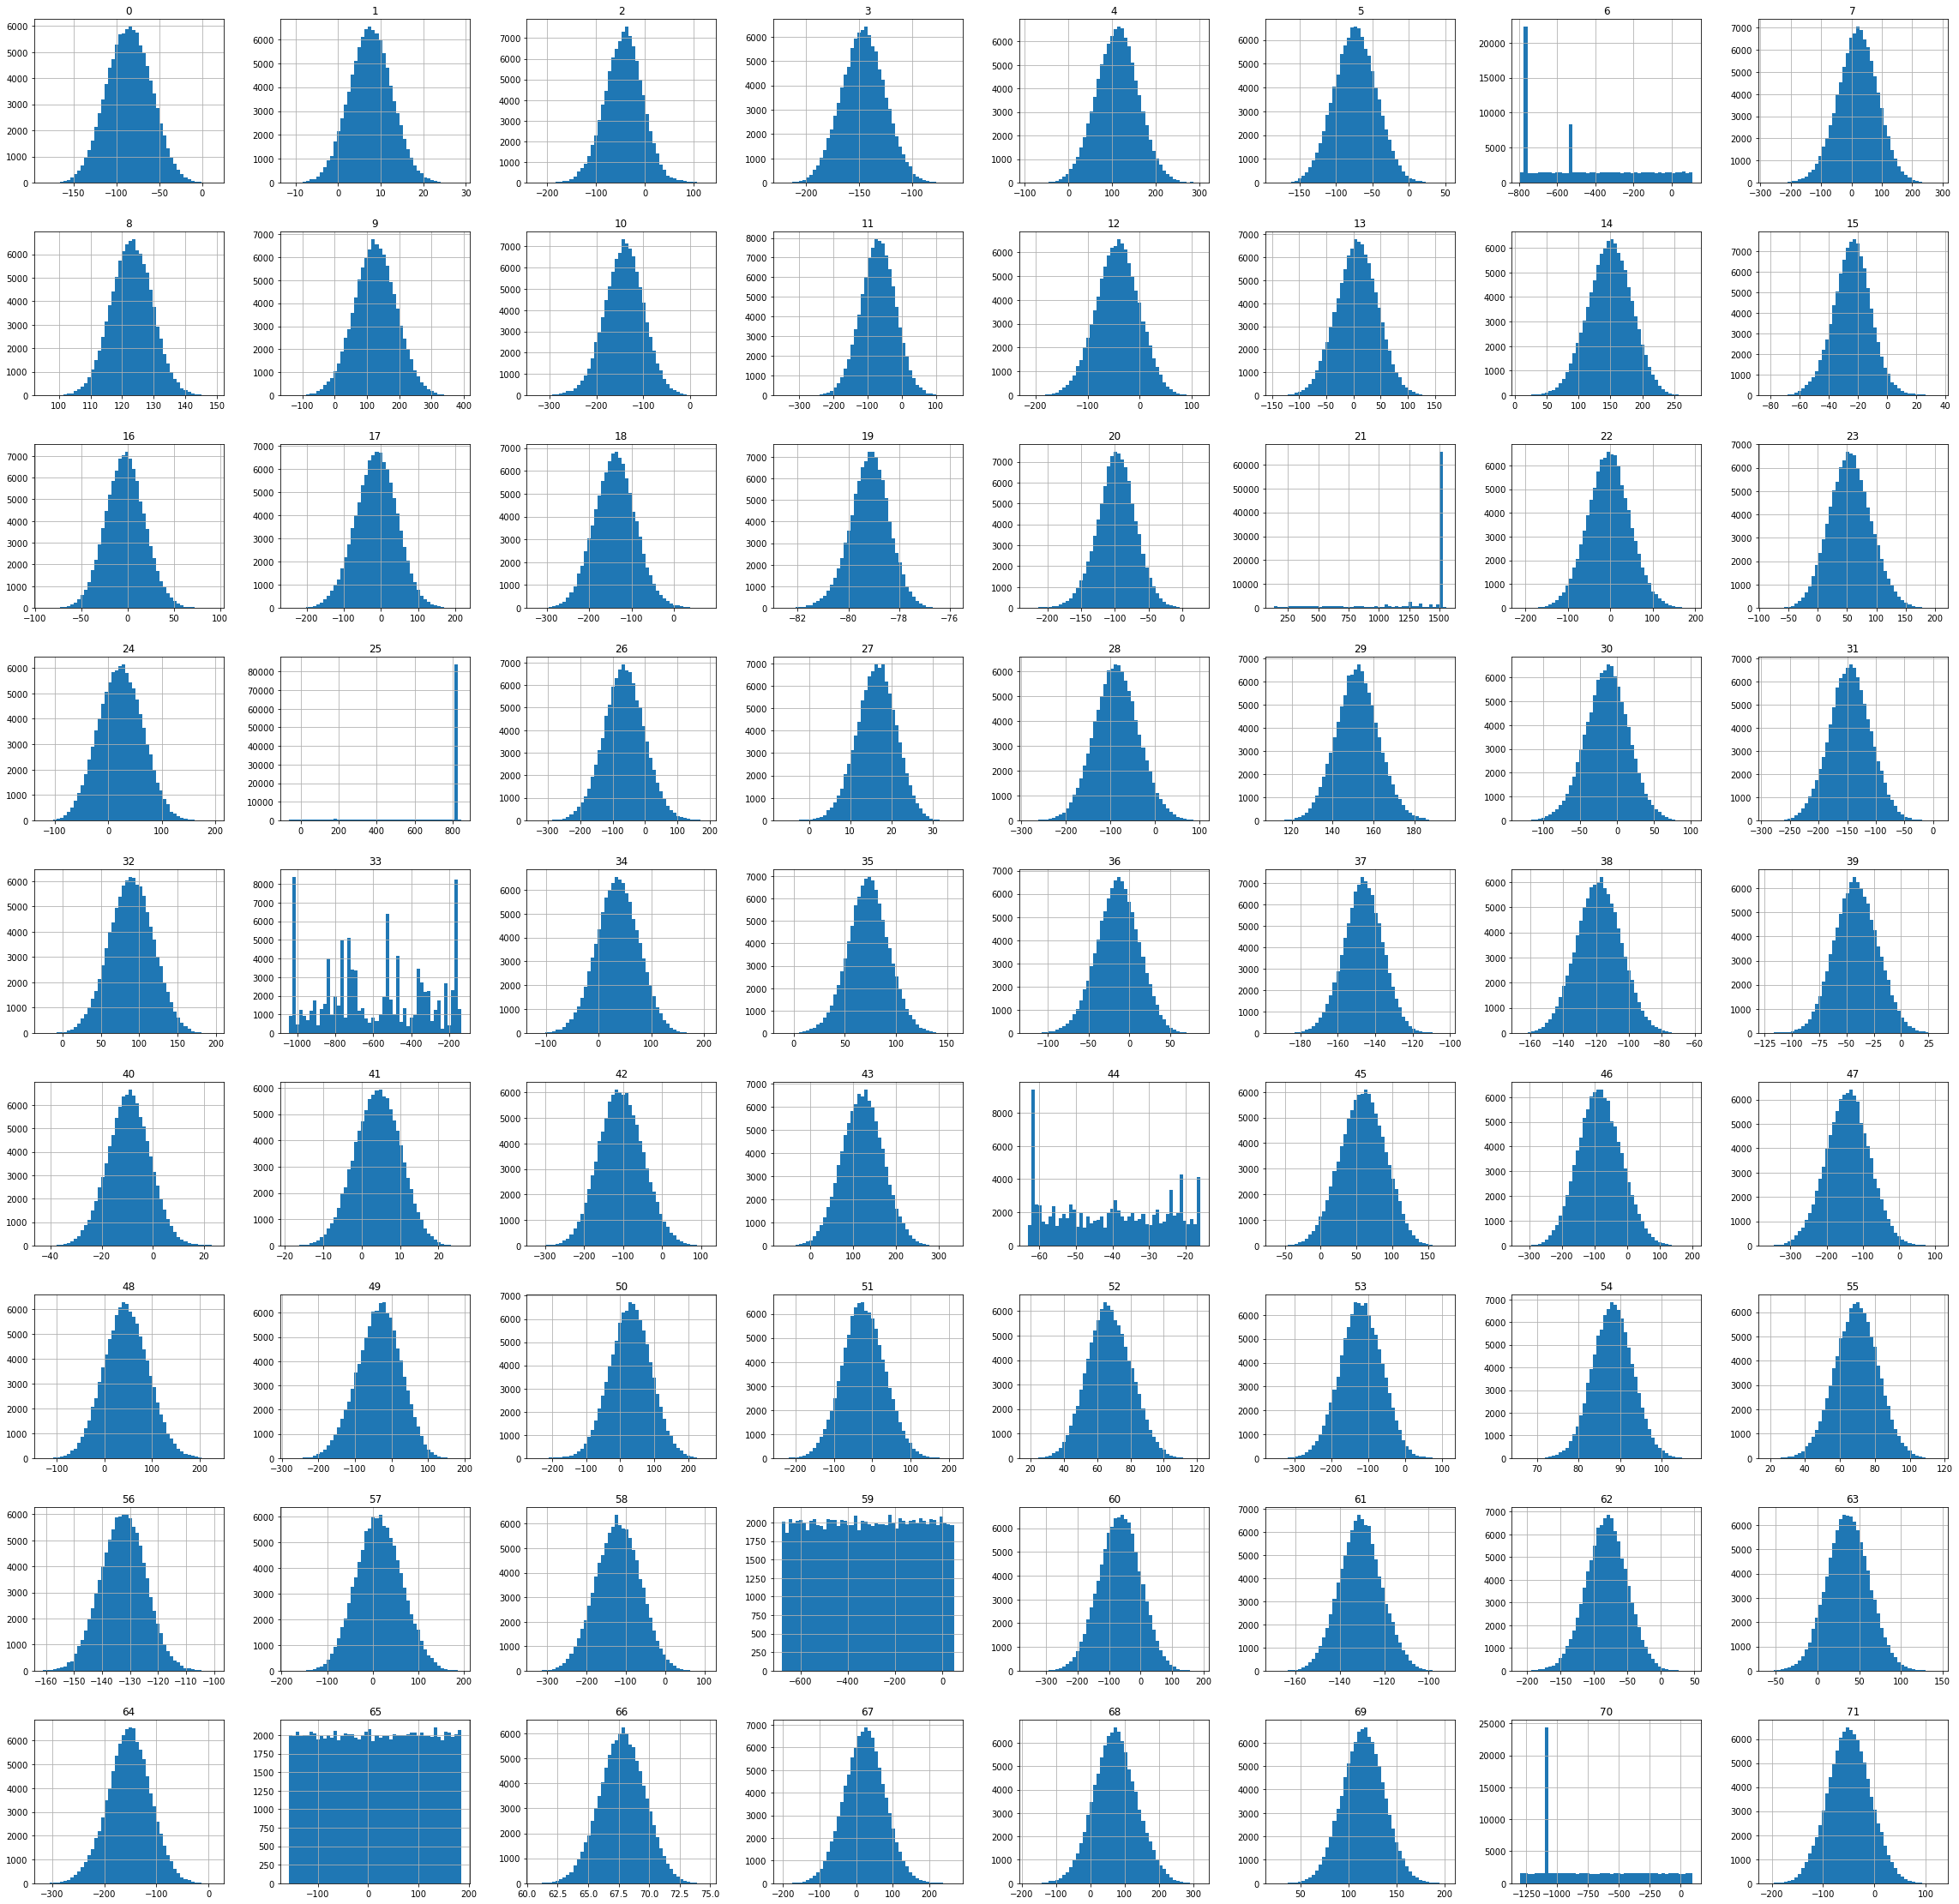

In [26]:
X_train.hist(bins=50, figsize=(40,40));

Краткий визуальный анализ полученных гистограмм признаков показывает, что большинство из них имеют нормальное или близкое к нормальному распределение, мат. ожидание, не равное нулю, и близкие по значению среднее арифметическое и медиану.<br>
Также графики показывают, что есть некоторые признаки, имеющие отличное от нормального (и даже не близкое к нему) распределение (номера 6, 21, 25, 33, 44, 59, 65, 70), - пожалуй, эти признаки являются наиболее интересными для анализа.

#### Признак `Target`

Рассмотрим целевой признак в обучающей выборке, определяющий жанр треков. Он является категориальным.

In [27]:
# информация о признаке
y_train.describe()

count         100000
unique         91794
top       41568-base
freq               7
Name: Target, dtype: object

С учетом количества уникальных значений признака выводить диаграмму распределения признака представляется нецелесообразным.

Результаты краткого исследования целевого признака показывают, что в значениях признака имеются повторы, при этом, в силу количества уникальных значений признака, изучить его на предмет неявных дубликатов и наличия дисбаланса (если это понятие в данном случае применимо) не представляется возможным (нужно проводить дополнительное объемное исследование?).<br>

#### Признак `0`

Данный признак является вещественным и по ранее выполненному предварительному анализу выглядит непрерывным, построим гистограмму и диаграмму размаха признака.

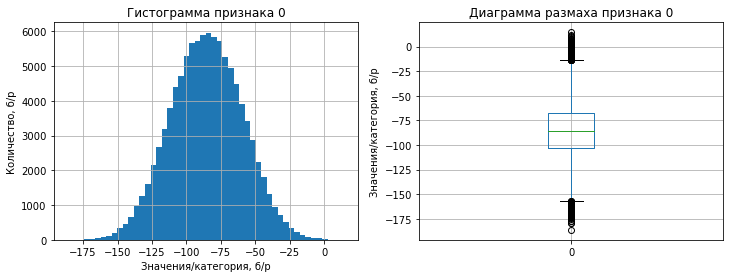

Среднее значение признака 0: -85.32867858750986 б/р
Медианное значение признака 0: -85.273695 б/р


In [28]:
feature_study(df=X_train, feature='0', bins_req=50, measure_unit='б/р')

Чтобы не усложнять тетрадку лишними разделами и забегая немного вперед, можно сказать, что результаты исследования данного признака и похожих признаков (см. общую гистограмму выше), имеющих околонормальное или нормальное распределения (кроме признаков с номерами 6, 21, 25, 33, 44, 59, 65, 70, отмеченных выше), показывают:
- признак имеет нормальное (близкое к нему) распределение (но смещенное мат. ожидание признака);
- среднее и медианное значения признака приблизительно равны;
- аномальные значения - присутствуют в достаточном количестве (согласно диаграмме размаха) - но при этом не являются аномальными значениями в полноценном понимании аномалий (не являются выбросами, искажающими общую картину распределения значений признака).

Посмотрим, какое количество значений остается, если не учитывать аномальные значения признака (являющиеся таковыми согласно диаграмме размаха).

In [29]:
X_train[(X_train['0'] < -155) | (X_train['0'] > -19)].shape

(665, 72)

Ок. 700 объектов у нас подлежат удалению. Поскольку признак выглядит неплохо и по умолчанию, попробуем не терять эти данные и пока оставим признак, как есть.

Все, подобные нулевому, признаки с нормальным распределением оказались похожи с точки зрения анализа (вид распределения, мат. ожидание, аномальные значения), поэтому их мы тоже не тронем и перейдем к рассмотрению выбивающихся из общего ряда признаков (номера которых отмечены выше, под общей гистограммой).

#### Признак `6`

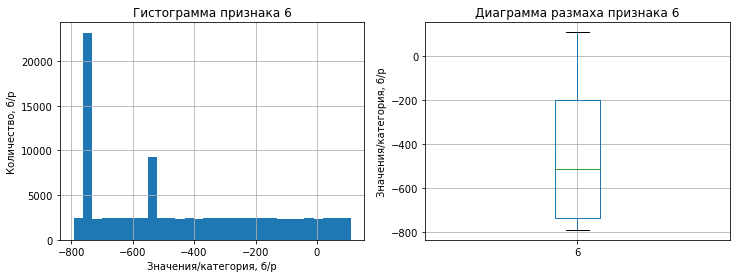

Среднее значение признака 6: -440.6151180373686 б/р
Медианное значение признака 6: -511.8377577524943 б/р


In [30]:
feature_study(df=X_train, feature='6', bins_req=30, measure_unit='б/р')

Это первый из признаков с не нормальным распределением (похоже на равномерное, но есть выбросы, их достаточно много - хотя при этом он не имеет аномальных значений согласно диаграмме размаха), с которым непонятно пока, что надо сделать. Он не является константным, не является нулевым, его нельзя просто так исключить из выборки, хотя, интуитивно кажется, что он будет мешать нашему поиску и модели обучения. Хотелось бы его удалить, но пока оставим в выборке.<br>
Одним из вариантов, что можно было бы сделать - заменить все значения на три, например: самое частое (ок. -750), второе по частоте (ок. -550) и остальные (которых по количеству менее 5000, например). Но в связи с тем, что времени экспериментировать не очень много, а результат такой замены - не факт, что даст какой-то выигрыш - не будем этого делать.

#### Признак `21`

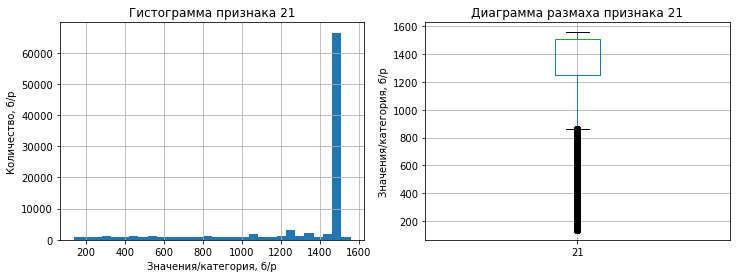

Среднее значение признака 21: 1297.2695779353028 б/р
Медианное значение признака 21: 1507.23127421948 б/р


In [31]:
feature_study(df=X_train, feature='21', bins_req=30, measure_unit='б/р')

Отфильтруем датасет по значению признака, частота которого выделяется из общей картины распределения и посмотрим, как изменится распределение в этом случае.

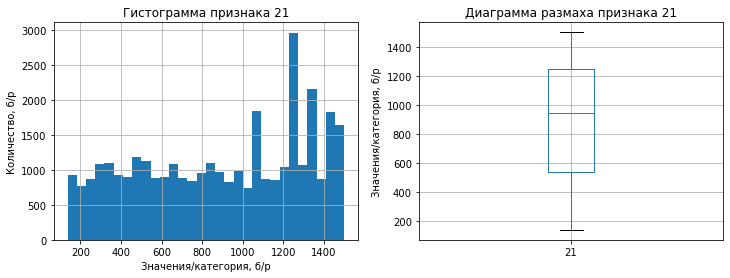

Среднее значение признака 21: 893.790867850835 б/р
Медианное значение признака 21: 941.5236307308212 б/р


In [32]:
feature_study(df=X_train[X_train['21'] < 1500], feature='21', bins_req=30, measure_unit='б/р')

Посмотрим, сколько объектов осталось в выборке после такой фильтрации.

In [33]:
X_train[X_train['21'] < 1500].shape

(34256, 72)

Увы, мы не можем себе позволить удалить более 2/3 данных из выборки просто так, тем более, что вид распределения особо не изменился (оно все так же ближе к равномерному, но с выбросами). Оставим признак пока как есть.<br>
Возможно, здесь можно было бы заменить признак бинарным: 1 - если значение признака равно самому часто встречающемуся (более 70000 по количеству объектов), 0 - остальные значения. Опять же, в силу отсутствия времени (проект пора уже сдавать, а у нас впереди еще - "игра" с FAISSом и ранжирующая модель) и гарантии, что это поможет улучшить качество поиска, оставим признак как есть.

#### Признак `25`

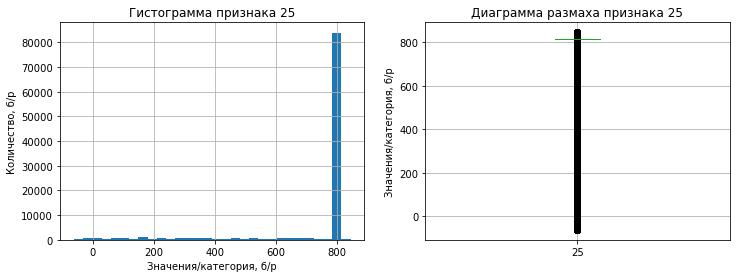

Среднее значение признака 25: 742.7888165806999 б/р
Медианное значение признака 25: 813.7700714289165 б/р


In [34]:
feature_study(df=X_train, feature='25', bins_req=30, measure_unit='б/р')

Отфильтруем датасет, посмотрим, сколько осталось объектов в выборке (аналогично предыдущему случаю).

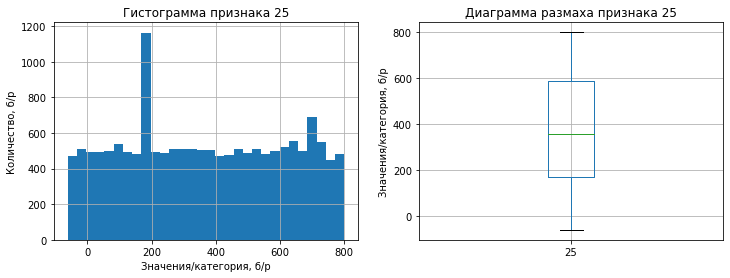

Среднее значение признака 25: 365.63187642705344 б/р
Медианное значение признака 25: 355.0226740532311 б/р


In [35]:
feature_study(df=X_train[X_train['25'] < 800], feature='25', bins_req=30, measure_unit='б/р')

Посмотрим, сколько объектов осталось в выборке после такой фильтрации.

In [36]:
X_train[X_train['25'] < 800].shape

(15855, 72)

Оставим признак и перейдем к следующему (равносильно, как и в предыдущем случае, возможно, надо было бы заменить на бинарный признак?).

#### Признак `33`

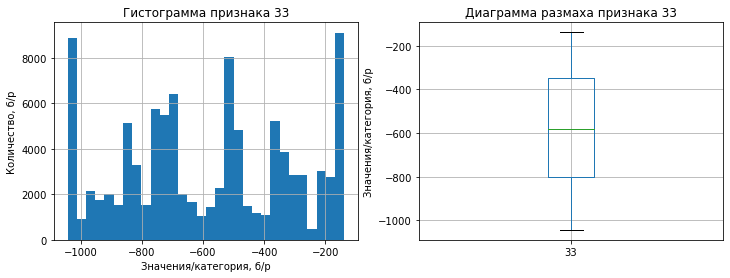

Среднее значение признака 33: -587.5517676084737 б/р
Медианное значение признака 33: -579.5903874885565 б/р


In [37]:
feature_study(df=X_train, feature='33', bins_req=30, measure_unit='б/р')

Признак не имеет ярко выраженного вида распределения, но в нем отсутствуют аномальные значения (согласно диаграмме размаха), среднее и медианные значения - близки, оставим признак и двинемся в обработке дальше.

#### Признак `44`

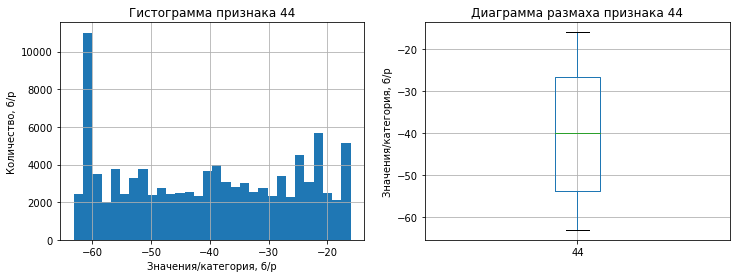

Среднее значение признака 44: -40.3202108380722 б/р
Медианное значение признака 44: -39.95456481840087 б/р


In [38]:
feature_study(df=X_train, feature='44', bins_req=30, measure_unit='б/р')

Двигаемся далее.

#### Признак `59`

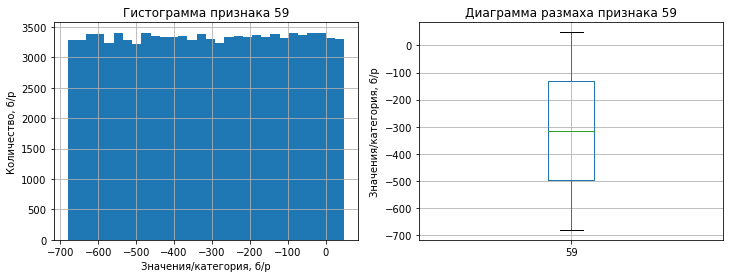

Среднее значение признака 59: -315.28223890201264 б/р
Медианное значение признака 59: -315.1772190530909 б/р


In [39]:
feature_study(df=X_train, feature='59', bins_req=30, measure_unit='б/р')

Статистики признака выглядят просто идеально (среднее и медиана - почти равны, аномальные значения - отсутствуют), но распределение признака не нормальное, больше похоже на равномерное. Пока непонятно, что делать и с этим признаком, оставим его в исходном виде.

#### Признак `65`

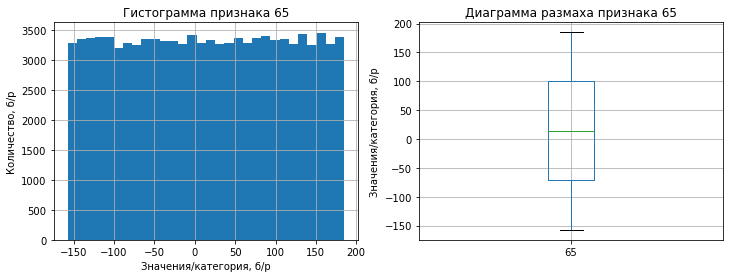

Среднее значение признака 65: 14.001695234429704 б/р
Медианное значение признака 65: 14.072662528028701 б/р


In [40]:
feature_study(df=X_train, feature='65', bins_req=30, measure_unit='б/р')

Ситуация с признаком аналогична ситуации с предыдущим (номер 59).

#### Признак `70`

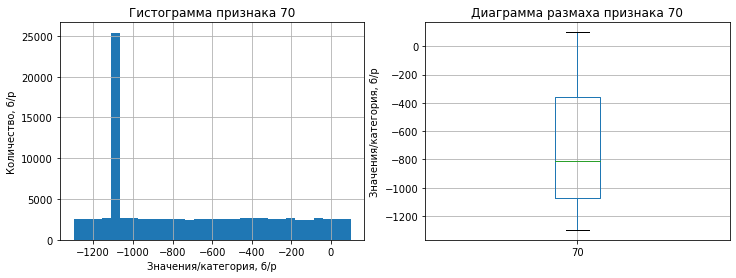

Среднее значение признака 70: -709.7615481263405 б/р
Медианное значение признака 70: -808.80169575276 б/р


In [41]:
feature_study(df=X_train, feature='70', bins_req=30, measure_unit='б/р')

Признак имеет выброс в районе значения -1100 (однако, это не визуализируется, как аномальное значение на диаграмме размаха), но это не подсказывает, как нам с этим признаком поступить. Оставим его пока без изменений.

По результатам краткого анализа признаков, выделяющихся из общей выборки (не имеющих нормального распределения), можно заключить, что пока удалить эти признаки из выборки мы не можем, никаких оснований у нас для этого нет. Попробуем выполнить масштабирование признаков, после чего еще раз проверим качество поиска с помощью FAISS.

### Разработка новых синтетических признаков

В разработку новых признаков (Feature Engineering) у нас (предварительно) войдет только один этап: обработка (нормализация/стандартизация/масштабирование) численных признаков (Feature Scaling), поскольку категориальные признаки в нашей выборке отсутствуют (формально таким признаком является целевой признак `Target`, но его кодирование мы выполнять не будем (у нас слишком много уникальных значений признака, кодировать его нецелесообразно).

Для начала определим столбцы выборок с численными признаками (исключая целевой признак).

In [42]:
num_cols = X_train.select_dtypes(include='number').columns # численные признаки

In [43]:
# проверка
num_cols

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

#### Нормализация (масштабирование) численных признаков

Выполним масштабирование численных признаков в полученных датафреймах признаков с помощью инструмента `StandardScaler` (на `RobustScaler-е` тоже было проверено, но результат оказался процентов на 10 хуже). Масштабирование выполним следующим образом: обучим скэйлер на базовой выборке, а потом применим его для преобразования признаков из обучающей и тестовой выборок.

In [44]:
# удалим X_train
del X_train

In [45]:
%%time
# создадим объект - скэйлер
scaler = StandardScaler()
# scaler = RobustScaler()

# обучим базовую выборку с отмасштабированными численными признаками
X_base = pd.DataFrame(scaler.fit_transform(df_base[num_cols]), index=df_base.index, columns=num_cols)

CPU times: total: 25.1 s
Wall time: 28.1 s


Трансформируем остальные выборки.

In [46]:
%%time
# X_train[num_cols] = scaler.transform(X_train[num_cols])
X_train = pd.DataFrame(scaler.transform(df_train[num_cols]), index=df_train.index, columns=num_cols)
X_test = pd.DataFrame(scaler.transform(df_test[num_cols]), index=df_test.index, columns=num_cols)

CPU times: total: 234 ms
Wall time: 312 ms


In [47]:
# проверим размерности
print(X_base.shape, X_train.shape, X_test.shape)

(2918139, 72) (100000, 72) (100000, 72)


Попробуем заново решить задачу мэтчинга, но уже с отмасштабированными выборками.

### Повышение качества мэтчинга

Снова создадим индекс для базового датасета с помощью библиотеки `faiss`.

In [48]:
dims = X_base.shape[1] # размерность вектора признаков для каждого объекта
n_cells = 50 # количество кластеров (ячейки Воронова?)
quantizer = faiss.IndexFlatL2(dims) # квантователь 
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией

Проверим, что индекс не обучен и затем - обучим его (на 50000 объектов - так было показано в лекции... не совсем понятно, - это для ускорения примера, или нам действительно достаточно обучить индекс на малом количестве данных?)...

In [49]:
print(idx_l2.is_trained)

False


In [50]:
idx_l2.train(np.ascontiguousarray(X_base.values[:50000, :]).astype('float32'))

In [51]:
print(idx_l2.is_trained)

True


Проверим, добавлены ли в индекс наши вектора признаков и добавим их.

In [52]:
print(idx_l2.ntotal)

0


In [53]:
%%time
idx_l2.add(np.ascontiguousarray(X_base.values).astype('float32'))

CPU times: total: 17.1 s
Wall time: 11.7 s


In [54]:
print(idx_l2.ntotal)

2918139


Выполним поиск ближайших соседей (повторим бейзлайн задачи мэтчинга), с учетом того, что нам необходимо найти 5 похожих товаров.

In [55]:
%%time
distx, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)

CPU times: total: 11min 15s
Wall time: 1min 43s


Найдем значение метрики (оценим качество алгоритма поиска), получающееся после масштабирования признаков датасетов.

In [56]:
%%time
print(acc_5(y_train, idx, base_index), '%')

54.981 %
CPU times: total: 3.92 s
Wall time: 1min 18s


### Проверка данных на мультиколлинеарность

Найдем матрицу коэффициентов корреляции признаков обучающей выборки (не включая целевой признак по причинам, описанным ранее - размер матрицы с закодированным целевым признаком) с использованием готовых функций библиотеки phik.<br>
При этом, не будем выводить значения и визуализировать (строить тепловую карту по найденной матрице коэффициентов корреляции признаков обучающей выборки) матрицу коэффициентов корреляции - в силу ее объемности она поместится для отображения на экране. Нам же важно лишь максимальное и минимальное значения в этой матрице.

In [57]:
%%time
# матрица коэффициентов корреляции признаков обучающей выборки
correlation_matrix = X_train.phik_matrix();
# correlation_matrix.round(2)

interval columns not set, guessing: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71']
CPU times: total: 2min 7s
Wall time: 3min 51s


Найдем максим. (но меньшее 1.0) и миним. значения коэффициентов корреляции.

In [58]:
correlation_matrix[correlation_matrix < 1.0].max().sort_values(ascending=False).head(1)

33    0.427656
dtype: float64

In [59]:
correlation_matrix.min().sort_values().head(1)

0    0.0
dtype: float64

Итак, максим. значение коэффициента $\phi_K$ равно 0.4276 (при минимальном, равном 0.0). Это говорит о том, что между признаками матрицы обучения нет сильной линейной зависимости (хотя бы уровня 0.9), а значит, - мы не можем удалить какие-то из признаков из матрицы.

### Выводы по разделу

В ходе проведенной работы было выполнено следующее:
- краткие предобработка и исследовательский анализ признаков обучающей выборки:
    - анализ показал, что большинство признаков имеют нормальное распределение, но ряд признаков (под номерами 6, 21, 25, 33, 44, 59, 65 и 70) - имеют распределение, отличное от нормального;
    - признаки, имеющие не нормальное распределение, не были обработаны (не удалялись "аномальные" значения, не удалялись целиком признаки из выборок), поскольку не совсем понятно, что можно с ними сделать и лучшим решением кажется оставить их без изменений. Но в отношении некоторых признаков имеется предположение, что можно их сделать бинарными (или состоящими из 3 значений, например);
- нормализация (масштабирование/стандартизация) численных (а это - фактически все признаки из датасетов, кроме целевого признака) признаков с помощью стандартного инструмента StandardScaler;
- проверка данных (обучающей выборки) на мультиколлинеарность. Проверка показала, что максимальное (по модулю) значение коэффициента фи-корреляции $\phi_K$ равно 0.4276 - такая слабая линейная зависимость признаков обучающей выборки не позволяет нам сделать вывод о возможности удаления каких-либо признаков из выборки;
- проверено качество решения задачи поиска похожих товаров для отмасштабированных (скэйлированых) данных, которая показала, что только лишь одна нормализация позволила повысить качество решения задачи мэтчинга с 8.693 %  до 54.981 % - более, чем в 6 раз, что уже является неплохим результатом (при прочих равных условиях).

Дополнительно необходимо отметить, что с целью повышения качества решения задачи была опробована редукция обучающей выборки с помощью метода PCA (с целью упрощения тетрадки здесь не приводятся эти исследования). К сожалению, сокращение количества признаков указанным методом не привело к повышению качества, но, возможно, требуется дополнительная работа по более тонкой настройке метода.<br>

Перейдем к попытке дополнительного повышения качества решения задачи мэтчинга с помощью исследования различных опций FAISS.

## Исследование опций FAISS

### Сжатие с потерями (Product Quantization)

Попробуем улучшить качество решаемой задачи за счет исследования различных опций алгоритма FAISS.

К использованным функциям работы с векторами индекса добавим метод Product Quantization (PQ).<br>
Создадим индекс, обучим его, добавим в него наши вектора признаков, выполним поиск и оценим качество решения задачи мэтчинга. Предварительно оставим прочие настройки FAISS как и раньше.

In [60]:
dims = X_base.shape[1] # размерность вектора признаков для каждого объекта
n_cells = 50 # количество кластеров (ячейки Воронова?)

m = 8  # number of centroid IDs in final compressed vectors
bits = 8 # number of bits in each centroid

quantizer = faiss.IndexFlatL2(dims) # квантователь 
idx_l2 = faiss.IndexIVFPQ(quantizer, dims, n_cells, m, bits) # создание индекса с кластеризацией

In [61]:
idx_l2.train(np.ascontiguousarray(X_base.values[:50000, :]).astype('float32'))

In [62]:
%%time
idx_l2.add(np.ascontiguousarray(X_base.values).astype('float32'))

CPU times: total: 2min 34s
Wall time: 7min 32s


In [63]:
%%time
distx, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)

CPU times: total: 1min 39s
Wall time: 34 s


In [64]:
%%time
print(acc_5(y_train, idx, base_index), '%')

49.178 %
CPU times: total: 2.38 s
Wall time: 40.1 s


Итак, навскидку, применение метода сжатия с потерями (PQ) не привело к ускорению процедур поиска и подсчета значения метрики, а вот качество (что и требовалось ожидать) - пострадало. Возможно, надо более тонко настроить этот метод (с PQ), но это тоже требует отдельного исследования без гарантии получения приемлемого результата.<br>
В дальнейших исследованиях опций FAISS вернемся к предыдущему варианту создания индекса, без применения метода PQ.

### Исследование некоторых опций алгоритма

Проведем процедры обучения индекса и поиска похожих товаров, варьируя значения таких опций алгоритма FAISS, как `n_cells` (количество кластеров, на которые разбивается датасет) и `nprobe` (количество кластеров, в которых производится поиск похожих товаров).

Поскольку не совсем понятно, можно ли для поиска по сетке параметров использовать какую-нибудь готовую функцию типа GridSearchCV, выполним исследование с поиском оптимальных значений параметров (опций) алгоритма вручную.

Зададим диапазоны значений параметров с большим шагом.

In [75]:
# диапазоны значений параметров алгоритма
n_cells_array = range(50, 201, 50)
nprobe_array = range(1, 10, 4)
best_n_cells = 1
best_nprobe = 1
best_acc_5 = 0
best_distx = []
best_idx = []

Выполним все процедуры по поиску ближайших соседей и расчету метрики качества поиска.

In [78]:
dims = X_base.shape[1] # размерность вектора признаков для каждого объекта
quantizer = faiss.IndexFlatL2(dims) # квантователь 

In [79]:
%%time
n_iter = 1
for n_cells in n_cells_array:
    for nprobe in nprobe_array:
#         print('iteration...', n_iter, 'n_cells...', n_cells, 'nprobe...', nprobe)
        idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией
        idx_l2.train(np.ascontiguousarray(X_base.values[:50000, :]).astype('float32'))
        idx_l2.add(np.ascontiguousarray(X_base.values).astype('float32'))
        idx_l2.nprobe = nprobe # количество кластеров для поиска
        distx, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)
        current_acc_5 = acc_5(y_train, idx, base_index)
        print('iteration...', n_iter, 'n_cells...', n_cells, 'nprobe...', nprobe,
              'acc@5...', current_acc_5)
        n_iter += 1
        if current_acc_5 > best_acc_5:
            best_acc_5 = current_acc_5
            best_n_cells = n_cells
            best_nprobe = nprobe
            best_distx = distx
            best_idx = idx

print('best acc@5:', best_acc_5, '%')
print('best_n_cells:', best_n_cells)
print('best_nprobe:', best_nprobe)

iteration... 1 n_cells... 50 nprobe... 1 acc@5... 54.981
iteration... 2 n_cells... 50 nprobe... 5 acc@5... 63.792
iteration... 3 n_cells... 50 nprobe... 9 acc@5... 64.524
iteration... 4 n_cells... 100 nprobe... 1 acc@5... 55.546
iteration... 5 n_cells... 100 nprobe... 5 acc@5... 63.728
iteration... 6 n_cells... 100 nprobe... 9 acc@5... 64.572
iteration... 7 n_cells... 150 nprobe... 1 acc@5... 55.318
iteration... 8 n_cells... 150 nprobe... 5 acc@5... 63.309
iteration... 9 n_cells... 150 nprobe... 9 acc@5... 64.336
iteration... 10 n_cells... 200 nprobe... 1 acc@5... 55.211
iteration... 11 n_cells... 200 nprobe... 5 acc@5... 63.371
iteration... 12 n_cells... 200 nprobe... 9 acc@5... 64.279
best acc@5: 64.572 %
best_n_cells: 100
best_nprobe: 9
CPU times: total: 6h 36min 53s
Wall time: 1h 2min 30s


Далее попробуем точечно искать некоторые значения параметров и вычислять значения метрики качества решения задачи мэтчинга.

In [80]:
n_cells = 1000
nprobe = 1

In [81]:
%%time
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией
idx_l2.train(np.ascontiguousarray(X_base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(X_base.values).astype('float32'))
idx_l2.nprobe = nprobe # количество кластеров для поиска
distx, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)
current_acc_5 = acc_5(y_train, idx, base_index)
print(current_acc_5, '%')

Еще один вариант.

In [84]:
n_cells = 1000
nprobe = 10

In [85]:
%%time
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией
idx_l2.train(np.ascontiguousarray(X_base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(X_base.values).astype('float32'))
idx_l2.nprobe = nprobe # количество кластеров для поиска
distx, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)
current_acc_5 = acc_5(y_train, idx, base_index)
print(current_acc_5, '%')

63.669 %
CPU times: total: 7min 52s
Wall time: 2min 42s


И так.

In [89]:
n_cells = 10
nprobe = 1

In [90]:
%%time
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией
idx_l2.train(np.ascontiguousarray(X_base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(X_base.values).astype('float32'))
idx_l2.nprobe = nprobe # количество кластеров для поиска
distx, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)
current_acc_5 = acc_5(y_train, idx, base_index)
print(current_acc_5, '%')

53.494 %
CPU times: total: 56min 29s
Wall time: 8min 15s


Уравняем количество ячеек и ячеек, в которых будет осуществляться поиск.

In [91]:
n_cells = 10
nprobe = 10

In [92]:
%%time
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией
idx_l2.train(np.ascontiguousarray(X_base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(X_base.values).astype('float32'))
idx_l2.nprobe = nprobe # количество кластеров для поиска
distx, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)
current_acc_5 = acc_5(y_train, idx, base_index)
print(current_acc_5, '%')

65.838 %
CPU times: total: 8h 29min 6s
Wall time: 1h 11min 58s


Вернемся к ранее найденным параметрам из диапазона и попробуем решить задачу, выбирая количество кластеров для поиска в "хорошем" диапазоне (с учетом ранее найденного значения nprobe=9), зафиксировав количество кластеров, на которые разбивается датасет.

In [99]:
# диапазоны значений параметров алгоритма
n_cells = 100
nprobe_array = range(9, 16, 1)
best_n_cells = 1
best_nprobe = 1
best_acc_5 = 0
best_distx = []
best_idx = []

In [100]:
%%time
n_iter = 1
for nprobe in nprobe_array:
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией
    idx_l2.train(np.ascontiguousarray(X_base.values[:50000, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(X_base.values).astype('float32'))
    idx_l2.nprobe = nprobe # количество кластеров для поиска
    distx, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)
    current_acc_5 = acc_5(y_train, idx, base_index)
    print('iteration...', n_iter, 'n_cells...', n_cells, 'nprobe...', nprobe,
          'acc@5...', current_acc_5)
    n_iter += 1
    if current_acc_5 > best_acc_5:
        best_acc_5 = current_acc_5
        best_n_cells = n_cells
        best_nprobe = nprobe
        best_distx = distx
        best_idx = idx

print('best acc@5:', best_acc_5, '%')
print('best_n_cells:', best_n_cells)
print('best_nprobe:', best_nprobe)

iteration... 1 n_cells... 100 nprobe... 9 acc@5... 64.572
iteration... 2 n_cells... 100 nprobe... 10 acc@5... 64.654
iteration... 3 n_cells... 100 nprobe... 11 acc@5... 64.747
iteration... 4 n_cells... 100 nprobe... 12 acc@5... 64.833
iteration... 5 n_cells... 100 nprobe... 13 acc@5... 64.92
iteration... 6 n_cells... 100 nprobe... 14 acc@5... 65.0
iteration... 7 n_cells... 100 nprobe... 15 acc@5... 65.062
best acc@5: 65.062 %
best_n_cells: 100
best_nprobe: 15
CPU times: total: 9h 9min 36s
Wall time: 1h 31min 53s


### Выводы по разделу

В силу отсутствия достаточного времени, чтобы свести в "красивую" таблицу все полученные при исследовании опций FAISS-а результаты, выполним просто их словесное описание.

По результатам проведенных исследований можно сделать следующие предварительные выводы:
- увеличение количества кластеров, на которые мы разбиваем датасет (n_cells), приводит к уменьшению времени поиска, но вместе с тем - и к снижению качества решаемой задачи;
- уменьшение количества кластеров, на которые разбиваем датасет - приводит к увеличению времени поиска и одновременно - к повышению качества задачи мэтчинга;
- также к росту качества поиска приводит увеличение количества кластеров, в которых будет осуществляться поиск (nprobe);
- к сожалению, в силу ограниченности времени и вычислительных ресурсов мы не можем промоделировать большое количество вариантов перебора этих двух параметров (n_cells и nprobe) с достаточно маленьким шагом, чтобы найти оптимальные значения этих параметров, а проведенные выше исследования дали лишь некие квазиоптимальные значения (к тому же, мы не можем утверждать, что эта гиперповерхность параметров - унимодальна);
- согласно проведенным исследованиям, наилучшие результаты дают значения n_cells = nprobe = 10 (65.838 %), однако, решение задачи мэтчинга с указанными значениями занимает очень длительное время.

Поскольку в нашем случае, в рамках работы над данным проектом, мы, пожалуй, не преследуем цель найти самые лучшие (оптимальные) значения параметров алгоритма, дающие максимальное качество при отсутствии ограничений на время поиска, то мы можем остановиться на таких значениях параметров и метрики качества: n_cells = 100, nprobe = 15, acc@5 = 65.062 %.

## Разработка ранжирующей модели

Признаться честно, всегда стараюсь делать проекты хорошо и до конца. Но в данном случае - время затянулось (я запаздываю на неделю, не могу начать следующий курс по SQL, а там будет тоже непросто, как я понимаю) - а как использовать все-таки тот же CatBoost (или какую-то другую модель) для построения ранжирующей модели - так до конца и не понял (только совсем приблизительно).<br>
Поскольку было ожидание, что больше полезного обучения будет в процессе работы над проектом, в т.ч., в первую очередь - со стороны ведущего этой Мастерской, то было очень удивительно, что такую важную тему, как ранжирование с помощью моделей ML (тем более, с такими объемами выборок, а хотелось бы поработать локально - так не отваливаются сессии (привет Collab и Kaggle) и можно быть уверенным, что результаты работы сохранятся в тетрадке), построение таких моделей и применение конкретно в нашем случае - никто подробно не объяснил.<br>
В связи с тем, что все сроки сдачи этой работы прошли, уделять время этому проекту уже нет возможности, прошу подсказать вариант, как разрешить эту проблему. Возможно, можно зачесть этот проект - был бы этому признателен и рад. Но при этом, все же, хотелось бы увидеть решение задачи от ПРОФЕССИОНАЛОВ, а не разбор проектов коллег-студентов, которые только учатся и могли сделать тоже не то что-то.<br>
Кстати, просмотрел видео с наставником курса - возникло ощущение, что и он не понял, как прикрутить кэтбуст (или другую модель) к решению данной задачи.<br>

## Общий вывод

По результатам проведенной работы с помощью библиотеки FAISS был разработан и протестирован алгоритм мэтчинга товаров, позволяющий каждому товару из валидационной выборки (та, которая, трэйн, но по факту она оказывается валидационной?) выборки сопоставить наиболее близкие товары из базовой выборки (по заданной метрике качества - acc@5).<br>
При решении данной задачи были выполнены следующие работы:
- проведен первичиный исследовательский анализ и предобработка данных исходных датасетов;
- найдены признаки, имеющие отличное от нормального распределения (под номерами 6, 21, 25, 33, 44, 59, 65 и 70), которые, скорее всего, являются препятствием для успешного обучения индекса FAISS (и последующего поиска похожих товаров) и возможных применяемых моделей;
- повторено базовое решение (бейзлайн) задачи мэтчинга, давшее ок. 8.6 % качество;
- проведена нормализация (масштабирование/стандартизация) признаков с помощью базового инструмента StandardScaler;
- проведена проверка данных на коллинеарность, получено макс. значение коэффициента фи-корреляции $\phi_K$, равное 0.4276 - такая слабая линейная зависимость признаков не позволила нам сделать математический вывод о возможности удаления каких-либо признаков из выборок;
- проверено качество решения задачи поиска похожих товаров для отмасштабированных (скэйлированых) данных, которая показала, что только лишь одна нормализация позволила повысить качество решения задачи мэтчинга с 8.693 %  до 54.981 % - более, чем в 6 раз, что уже является неплохим результатом (при прочих равных условиях);
- проведено исследование опций алгоритма (функций библиотеки FAISS), таких как, количество кластеров, на которые разбивается выборка (n_cells) и количество соседних кластеров, в которых осуществляется поиск после разбиения на n_cells кластеров и нахождения центроидов данных кластеров (nprobe). Исследование показало, что, в целом, - качество растет с увеличением nprobe и падает с увеличением n_cells, время поиска при этом изменяется обратно пропорционально (например, растет с уменьшением n_cells);
- в неких небольших диапазонах изменения указанных параметров, наилучшие результаты дают значения n_cells = nprobe = 10 (65.838 %), однако, решение задачи мэтчинга с указанными значениями занимает очень длительное время;
- значения параметров алгоритма, дающие максимальное качество при отсутствии ограничений на время поиска, получились следующие (опять же, в некоторых небольших изменениях диапазонов данных параметров): n_cells = 100, nprobe = 15. Значение метрики качества при этом равно acc@5 = 65.062 %.

Дальнейшие возможные шаги по улучшению алгоритма (которые можно было бы выполнить при наличии достаточного количества времени и более детального понимания построения ранжирующей модели для нашего случая):
- дополнительное исследование и предобработка признаков (удаление "лишних", удаление "аномалий");
- синтез новых признаков или редукция имеющихся (хотя, попытка применить PCA привела к худшим результатам);
- поиск значений параметров FAISS в более серьезных диапазонах возможных значений этих параметров (необходимо учитывать длительность времени при работе локально);
- применение модели ML (DL) для решения задачи ранжирования.